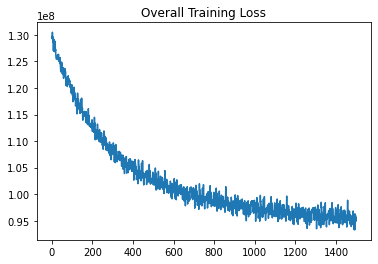

In [2]:
import pandas as pd

loss_history=pd.read_csv('./save/loss_history.csv')

loss_history.loss.plot(title = "Overall Training Loss")

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import re
import json
import time
import pickle
import argparse
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from gensim.corpora import Dictionary
from collections import deque, Counter

import torch

from dynamic_bernoulli_embeddings.training import train_model

unable to import 'smart_open.gcs', disabling that module


In [2]:
parser = argparse.ArgumentParser(description='DWE argparser')
# Path Setting
parser.add_argument('--data_path', type=str, default='../joseon_word_embedding/data/', 
                    help='Data path setting')
parser.add_argument('--save_path', type=str, default='./save2',
                    help='Save path setting')
# Training Setting
parser.add_argument('--num_epochs', type=int, default=5, help='The number of epoch')
args = parser.parse_args(list())

In [3]:
# Data List Setting
data_path = glob(os.path.join(args.data_path, '*.json'))
data_path = sorted(data_path)[:-1] # 순종부록 제거

# Preprocessing
total_counter = Counter()
king_list = list()
king_index_list = list()
comment_list = list()

# start_time = time.time()
for ix, path in enumerate(tqdm(data_path)):
    with open(path, 'r') as f:
        record_list = json.load(f)
        king_list.append(path.split(' ')[-1][:2])
        king_index_list.append(ix)
        total_record = list()

        for rc in record_list:
            total_record.append(rc['hanja'])
        total_record = ' '.join(total_record)
        new_word = re.sub(pattern='[^\w\s]', repl='', string=total_record)
        new_word = re.sub(pattern='([ㄱ-ㅎㅏ-ㅣ]+)', repl='', string=new_word)
        new_word = re.sub(pattern='[\u3131-\u3163\uac00-\ud7a3]+', repl='', string=new_word)
        new_word = re.sub(pattern='[a-zA-Z0-9]+', repl='', string=new_word)
        comment_list.append(new_word)
        total_counter.update(new_word)

100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


In [4]:
vocab = list(total_counter.keys())
vocab.insert(0, '<unk>')
vocab.insert(0, '</s>')
vocab.insert(0, '<s>')
vocab.insert(0, '<pad>')
word2id = {w: i for i, w in enumerate(vocab)}

# Dataset Setting
dataset = pd.DataFrame({
    'session': king_list,
    'text': comment_list,
    'time': king_index_list
})
dataset['bow'] = dataset['text'].apply(lambda x: [i for i in x])

# Generate dictionary.
dictionary = Dictionary(dataset.bow)
dictionary.filter_extremes(no_below=15, no_above=1.)
dictionary.compactify()

In [5]:
import numpy as np
import pandas as pd
import torch

from dynamic_bernoulli_embeddings.embeddings import DynamicBernoulliEmbeddingModel
from dynamic_bernoulli_embeddings.preprocessing import Data

In [6]:
validation = None
dictionary = word2id
num_epochs = args.num_epochs
notebook = True

In [ ]:
# Check for gpu.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Create a validation set.
validation_mask = np.repeat(False, dataset.shape[0])
if validation is not None:
    assert 0 < validation < 1
    validation_mask = np.random.random(dataset.shape[0]) < validation
data = Data(dataset[~validation_mask], dictionary, device)
data_val = Data(dataset[validation_mask], dictionary, device)

In [ ]:
"""Contains embedding model implementation"""
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

class DynamicBernoulliEmbeddingModel(nn.Module):
    def __init__(
        self,
        V,
        T,
        m_t,
        dictionary,
        sampling_distribution,
        k=256,
        lambda_=1e4,
        lambda_0=1,
        ns=20,
    ):
        """
        Parameters
        ----------
        V : int
            Vocabulary size.
        T : int
            Number of timesteps.
        m_t : dict
            The total number of tokens in each timestep to compute the scaling factor
            for the pseudo log likelihoods.
        dictionary : dict
            Maps word to index.
        sampling_distribution : tensor (V,)
            The unigram distribution to use for negative sampling.
        k : int
            Embedding dimension.
        lambda_ : int
            Scaling factor on the time drift prior.
        lambda_0 : int
            Scaling factor on the embedding priors.
        ns : int
            Number of negative samples.
        """
        super().__init__()
        self.V = V  # Vocab size.
        self.T = T  # Number of timestepss.
        self.k = k  # Embedding dimension.
        self.total_tokens = sum(m_t.values())  # Used for scaling factor for pseudo LL
        self.lambda_ = lambda_  # Scaling factor on the time drift prior.
        self.lambda_0 = lambda_0  # Scaling factor on the embedding priors.
        self.sampling_distribution = Categorical(logits=sampling_distribution)
        self.negative_samples = ns  # Number of negative samples.
        self.dictionary = dictionary
        self.dictionary_reverse = {v: k for k, v in dictionary.items()}

        # Embeddings parameters.
        self.rho = nn.Embedding(V * T, 50)  # Stacked dynamic embeddings # 이부분
        self.rho2 = nn.Linear(50, k)
        self.alpha = nn.Embedding(V, 50)  # Time independent context embeddings # 이부분
        self.alpha2 = nn.Linear(50, k)
        with torch.no_grad():
            nn.init.normal_(self.rho.weight, 0, 0.01)
            nn.init.normal_(self.alpha.weight, 0, 0.01)

        # Transformations
        self.log_sigmoid = nn.LogSigmoid()
        self.sigmoid = nn.Sigmoid()

    def L_pos(self, eta):
        return self.log_sigmoid(eta).sum()

    def L_neg(self, batch_size, times, contexts_summed):
        neg_samples = self.sampling_distribution.sample(
            torch.Size([batch_size, self.negative_samples])
        )
        neg_samples = neg_samples + (times * self.V).reshape((-1, 1))
        neg_samples = neg_samples.T.flatten() # 이부분
        context_flat = contexts_summed.repeat((self.negative_samples, 1))
        testing = self.rho(neg_samples)
        eta_neg = (self.rho2(self.rho(neg_samples)) * context_flat).sum(axis=1)
        return (torch.log(1 - self.sigmoid(eta_neg) + 1e-7)).sum()

    def forward(self, targets, times, contexts, validate=False, dynamic=True):
        """Forward pass of the model

        Parameters
        ----------
        targets : (batch_size,)
        times : (batch_size,)
        contexts : (batch_size, 2 * context_size)
        dynamic : bool
            Indicates whether to include the drift component of the loss.

        Returns
        -------
        loss
        L_pos
        L_neg
        L_prior
        """
        batch_size = targets.shape[0]
        print(f'Dynamic : {dynamic}')

        # Since the embeddings are stacked, adjust the indices for the targets.
        # In other words, word `i` in time slice `j` would be at position
        # `j * V + i` in the embedding matrix where V is the vocab size.
        targets_adjusted = times * self.V + targets

        # -1 indicates out of bounds for the context word, so mask these out so
        # they don't contribute to the context sum.
        context_mask = contexts == -1
        contexts[context_mask] = 0
        contexts = self.alpha2(self.alpha(contexts))
        contexts[context_mask] = 0
        contexts_summed = contexts.sum(axis=1)
        print(self.rho(targets_adjusted).size())
        print(self.rho2(self.rho(targets_adjusted)))
        eta = (self.rho2(self.rho(targets_adjusted)) * contexts_summed).sum(axis=1)

        # Loss
        loss, L_pos, L_neg, L_prior = None, None, None, None

        L_pos = self.L_pos(eta)
        if not validate:
            L_neg = self.L_neg(batch_size, times, contexts_summed)
            loss = (self.total_tokens / batch_size) * (L_pos + L_neg)
            L_prior = -self.lambda_0 / 2 * (self.alpha.weight ** 2).sum()
            L_prior += -self.lambda_0 / 2 * (self.alpha2.weight ** 2).sum()
            L_prior += -self.lambda_0 / 2 * (self.rho.weight[0] ** 2).sum()
            L_prior += -self.lambda_0 / 2 * (self.rho2.weight[0] ** 2).sum()
            if dynamic:
                print('Dynamic!!')
                print(self.T)
                print(self.V)
                rho_trans = self.rho.weight.reshape((self.T, self.V, 50))
                print(rho_trans.size())
                print(f'Weight: {self.rho2.weight.size()}')
                rho_trans2 = self.rho2.weight.reshape((self.T, self.V, self.k))
                print(rho_trans2.size())
                L_prior += (
                    -self.lambda_ / 2 * ((rho_trans[1:] - rho_trans[:-1]) ** 2).sum()
                )
                L_prior += (
                    -self.lambda_ / 2 * ((rho_trans2[1:] - rho_trans2[:-1]) ** 2).sum()
                )
            loss += L_prior
            loss = -loss

        return loss, L_pos, L_neg, L_prior

    def get_embeddings(self):
        """Gets trained embeddings and reshapes them into (T, V, k)"""
        embeddings = (
            self.rho.cpu()
            .weight.data.reshape((self.T, len(self.dictionary), self.k))
            .numpy()
        )
        return embeddings


In [ ]:
# Build model.
model = DynamicBernoulliEmbeddingModel(
    len(data.dictionary),
    data.T,
    data.m_t,
    dictionary,
    data.unigram_logits
)
model = model.to(device)

In [ ]:
model

In [ ]:
m = 300
i = 1
pbar = tqdm(enumerate(data.epoch(m)), total=m)
pbar.set_description(f"Epoch {i}")
for j, (targets, contexts, times) in pbar:
    model.train()
    model.zero_grad()
    # The first epoch ignores time for initializing weights.
    if i == 1:
        times = torch.zeros_like(times)
    loss, L_pos, L_neg, L_prior = model(targets, times, contexts, dynamic=i > 0)
    break

In [ ]:
12800 / 27

In [ ]:
1350 / 27

In [ ]:
targets.size()

In [ ]:
total_bow = list()
for b in dataset['bow']:
    total_bow.extend(b)

In [ ]:
type(total_bow)

In [ ]:
len(total_bow)

In [ ]:
55445088/184833

In [ ]:
184833 * 300